rossler1d
0
RBFLN-RE-transform


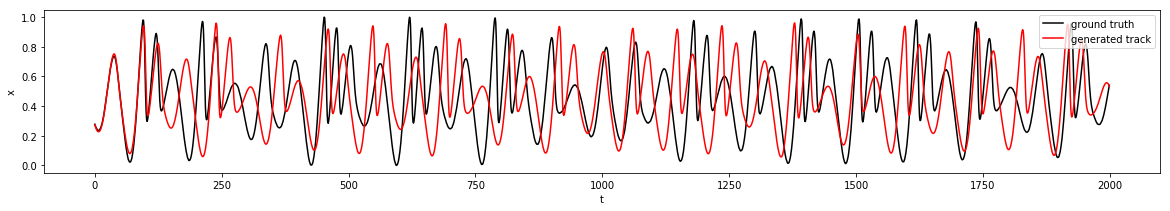

1
RBFLN-RE-transform


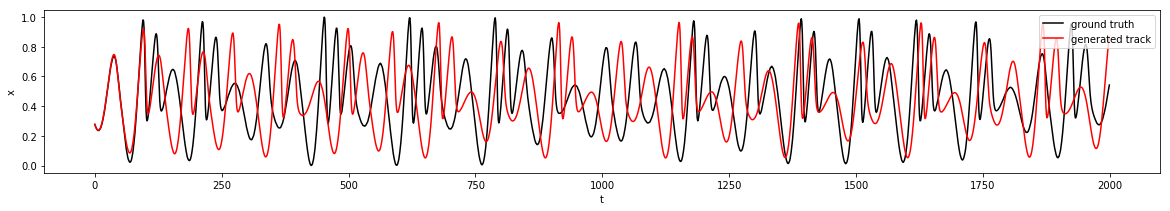

2
RBFLN-RE-transform


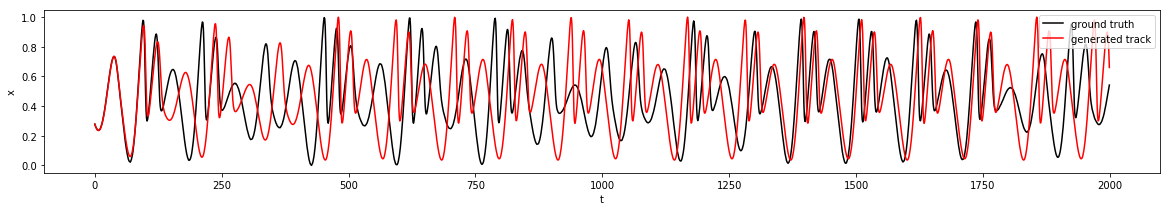

rabinovich_fabrikant1d
0
RBFLN-RE-transform


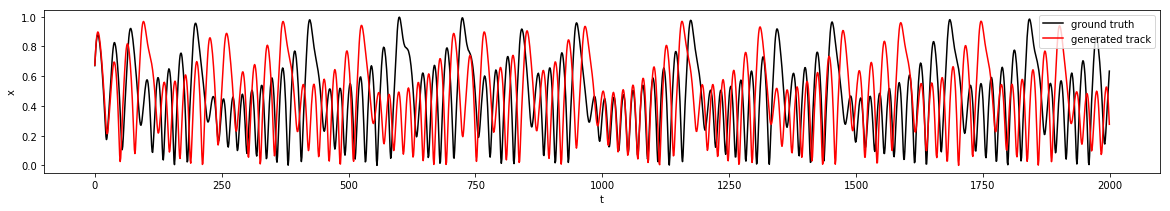

1
RBFLN-RE-transform


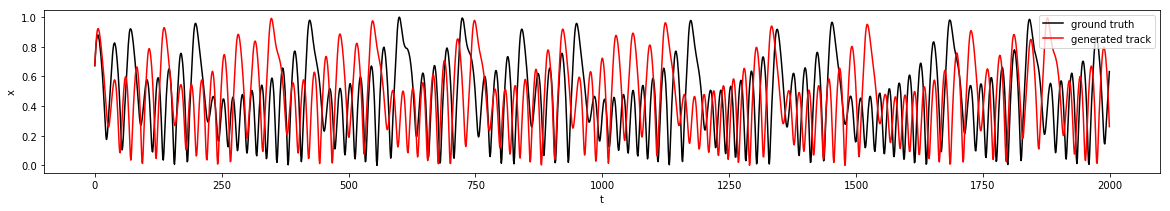

2
RBFLN-RE-transform


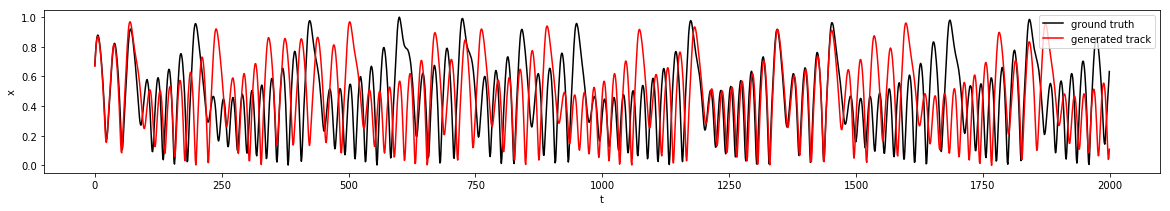

lorentz1d
0
RBFLN-RE-transform


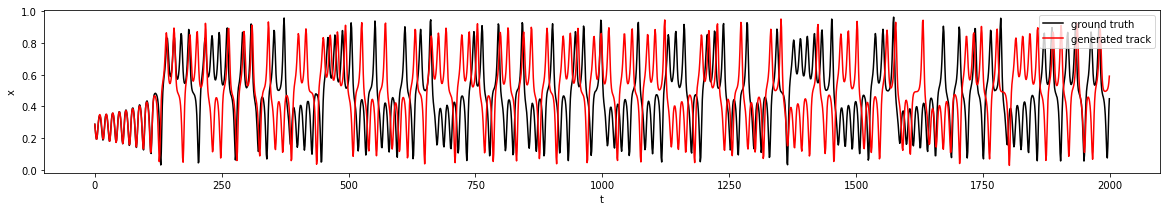

1
RBFLN-RE-transform


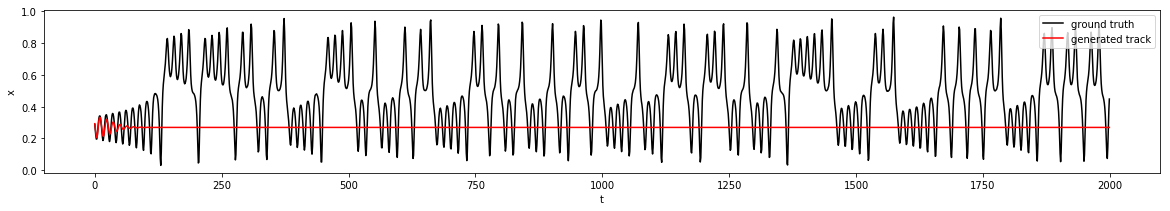

2
RBFLN-RE-transform


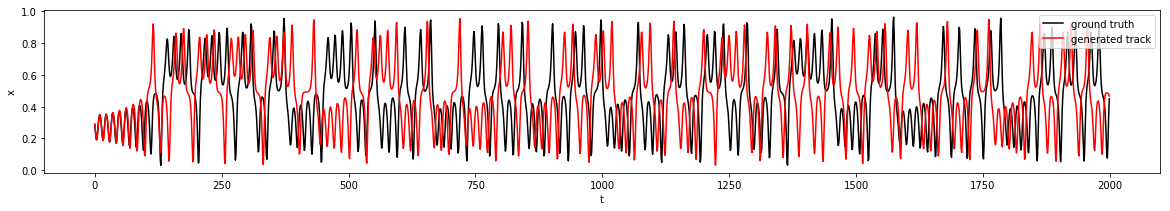

chua1d
0
RBFLN-RE-transform


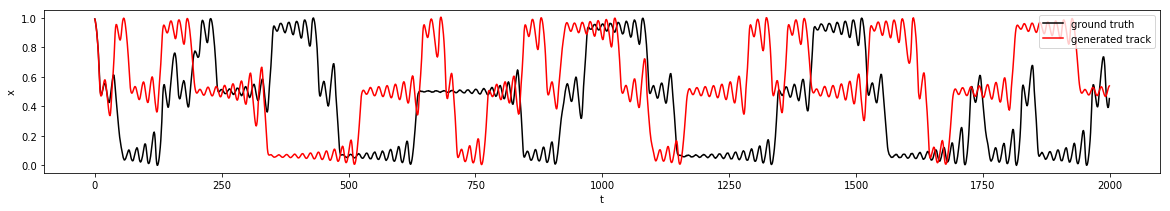

1
RBFLN-RE-transform


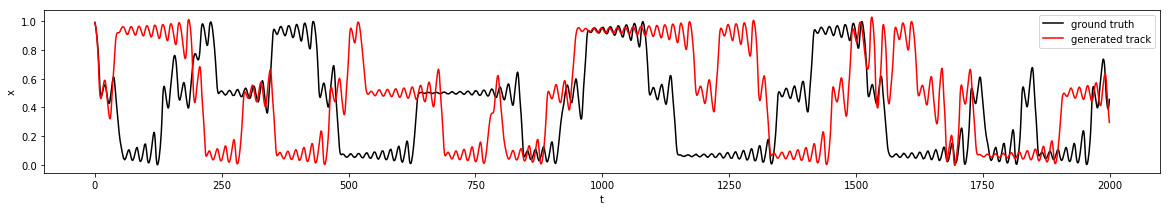

2
RBFLN-RE-transform


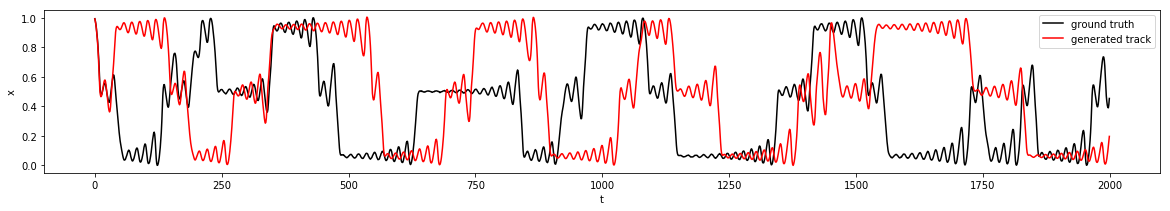

In [16]:

# !/usr/bin/env python
# -*- coding: utf-8 -*-

from nolds.measures import poly_fit
from nolitsa import data, lyapunov
from nolitsa.d2 import *
import numpy as np
import matplotlib.pyplot as plt
from RBFNN import *
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from utils import *

class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__



names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
    'chua',
]
names = [n + '1d' for n in names]

n_dim = 1
horizon = 1
N = 10000
n_history = 10  # 使用 n 个历史点作为输入
N_h = 200
num_prepare = 10
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
reservoirConf = Dict(
    alpha=0.9,
    connectivity= 1,
    nz= 100,
    nu = n_dim,
    target_rho=0.99,
    input_scale= 1,
#     activation = lambda x: 1/(1 + np.exp(-x))  # sigmoid
#     activation = lambda x: np.maximum(0,x)
#     activation = lambda x: x/(1 + np.exp(-x))
    activation = np.tanh
#     activation = lambda x: np.sin(x)
)



def gen_model(conf):
    _, model_type, kwargs = conf
    conf_dict = dict(
        model_type=model_type,
        **kwargs
    )
    return RBFNN(**conf_dict)

def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        model = gen_model(conf)
        model.train(x_train, y_train, num_prepare)
        Predictions = model.predict(x_test, num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model


for system_name in names:
    print(system_name)
    for i,num_prepare in enumerate([0]*3):
        print(i)
        for n_history in [20]:
            x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
            x += np.random.randn(*x.shape)*0.001

            x_train = np.vstack([select_samples(x, train_start + i, num_train + num_prepare) for i in range(n_history)])
            x_test = np.vstack([select_samples(x, test_start + i, num_test + num_prepare) for i in range(n_history)])
            y_test = select_samples(x, test_start + num_prepare + n_history, num_test)
            y_train = select_samples(x, train_start + num_prepare + n_history, num_train)


            model_confs = []
#             model_confs.append(
#                 [('ESN-trannsform', 
#                 ModelType.ESN, 
#                 dict(reservoirConf=reservoirConf,encoder='transform',skip_con=0))]
#             )
            
#             model_confs.append(
#                 [('ESN-echostate', 
#                 ModelType.ESN, 
#                 dict(reservoirConf=reservoirConf,encoder='echostate',skip_con=0))]
#             )

            model_confs.append(
                [('RBFLN-RE-transform', 
                ModelType.RBFLN_RE, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf, encoder='transform')) 
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
#             model_confs.append(
#                 [('RBFLN-RE-echostate', 
#                 ModelType.RBFLN_RE, 
#                 dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf, encoder='echostate')) 
#                 for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             )

#             model_confs.append(
#                 [('ESN-ATTN-transform',
#                 ModelType.ESN_ATTN, 
#                 dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf,encoder='transform'))
#                 for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             )


            for j, confs in enumerate(model_confs):

                conf = select_model(confs)

                model_name, model_type, kwargs = conf
                print(model_name)

                conf_dict = dict(
                    model_type=model_type,
                    **kwargs
                )

                model = RBFNN(**conf_dict)
                model.train(x_train, y_train, num_prepare)

                if kwargs['encoder'] == 'echostate':
                    y_pred = model.predict_multistep_esn(x_test[:,:num_prepare+1], num_test)
                elif kwargs['encoder'] == 'transform':
                    y_pred = model.predict_multistep(x_test[:, num_prepare:num_prepare+1], num_test)
                else:
                    assert(False)
                y_pred = y_pred.reshape((num_test,n_dim)).T


                try:
                    plt.figure(figsize=(20, 3))
                    dim = ['x', 'y', 'z']
                    for i in range(n_dim):
                        plt.subplot(n_dim, 1, i + 1)
                        plt.plot(y_test[i].T, color='black', label='ground truth')
                        plt.plot(y_pred[i].T, color='red', label='generated track')
                        plt.ylabel(dim[i])
                        if i == 0:
                            plt.legend(loc='upper right')
                    plt.xlabel('t')
                    plt.show()
                except Exception as e:
                    pass










In [ ]:
def CD(x):
    r, c = c2(x,  metric='euclidean')
    r, c = np.log(r), np.log(c)
    coefs = poly_fit(r, c, 1)
    print('LLE = ', coefs[0])

    plt.figure()
    plt.title('corr sum for the '+system_name)
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
    plt.plot(r, c, label='divergence')
    plt.plot(r, coefs[1] + coefs[0] * r, '--', label='RANSAC')
    plt.legend()
    # plt.show()
    # d1 = d2(r, c)
    return coefs[0]


def LLE(x):
    dt = 0.01
    meanperiod = 10
    maxt = 150
    # d = lyapunov.mle(x, maxt=maxt, window=meanperiod)
    d = lyapunov.mle_embed(np.squeeze(x), dim=[5], maxt=maxt, window=meanperiod, parallel=False)
    d = np.squeeze(d)
    t = np.arange(maxt) * dt
    coefs = poly_fit(t, d, 1)
    print('LLE = ', coefs[0])

    plt.figure()
    plt.title('Maximum Lyapunov exponent for the '+system_name)
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
    plt.plot(t, d, label='divergence')
    plt.plot(t, coefs[1] + coefs[0] * t, '--', label='RANSAC')
    plt.legend()
    # plt.show()

    return coefs[0]


print('LLE test:', LLE(y_test.T))
print('LLE pred:', LLE(y_pred.T))
#
# print('CD test:', CD(x.T))
# print('CD pred:', CD(y_gen.T))
print('CD test:', CD(y_test.T))
print('CD pred:', CD(y_pred.T))